Importing relevant packages

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import zipfile
from keras.applications.vgg16 import VGG16
import keras
from keras import regularizers

In [2]:
#Unzip the file and extract as stage1_train folder
with zipfile.ZipFile("stage1_train.zip","r") as zip_ref:
    zip_ref.extractall("stage1_train")

In [3]:
#Unzip the file and extract as stage1_test folder
with zipfile.ZipFile("stage1_test.zip","r") as zip_ref:
    zip_ref.extractall("stage1_test")

In [21]:
#Set up model hyperparameters
SEED = 12345

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [22]:
#insert path file for train and test dataset
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

In [23]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

C:\Users\User\AppData\Local\Temp/ipykernel_14408/125045689.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [24]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

Resizing training images and masks


C:\Users\User\AppData\Local\Temp/ipykernel_14408/118592298.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [12:35<00:00,  1.13s/it]


In [25]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
print('Done!')

  5%|███▊                                                                               | 3/65 [00:00<00:02, 23.48it/s]

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.00it/s]

Done!


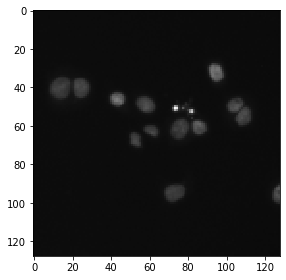

(128, 128, 1)
(128, 128)


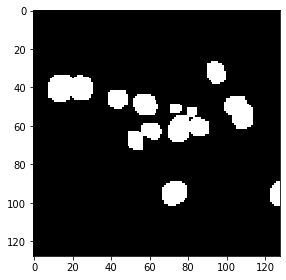

In [26]:
#plotting the image of features,X and label,Y
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
print(Y_train[image_x].shape)
print(np.squeeze(Y_train[image_x]).shape)
imshow(np.squeeze(Y_train[image_x]))
plt.show()

Build base model of MobileNetV2 and model of U-Net by implement strategy of transfer learning, 
Pre-trained Models as Feature Extractors
<img src="Picture2.jpg" alt="">

In [31]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], 
                                               include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Below is a model of U-Net which is not used for a while. 

In [33]:
'''
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.2)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.3)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.3)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.4)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
'''

"\ninputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))\ns = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)\n\n#Contraction path\nc1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)\nc1 = tf.keras.layers.Dropout(0.2)(c1)\nc1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)\np1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)\n\nc2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)\nc2 = tf.keras.layers.Dropout(0.2)(c2)\nc2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)\np2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)\n \nc3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)\nc3 = tf.keras.layers.Dropout(0.3)(c3)\nc3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializ

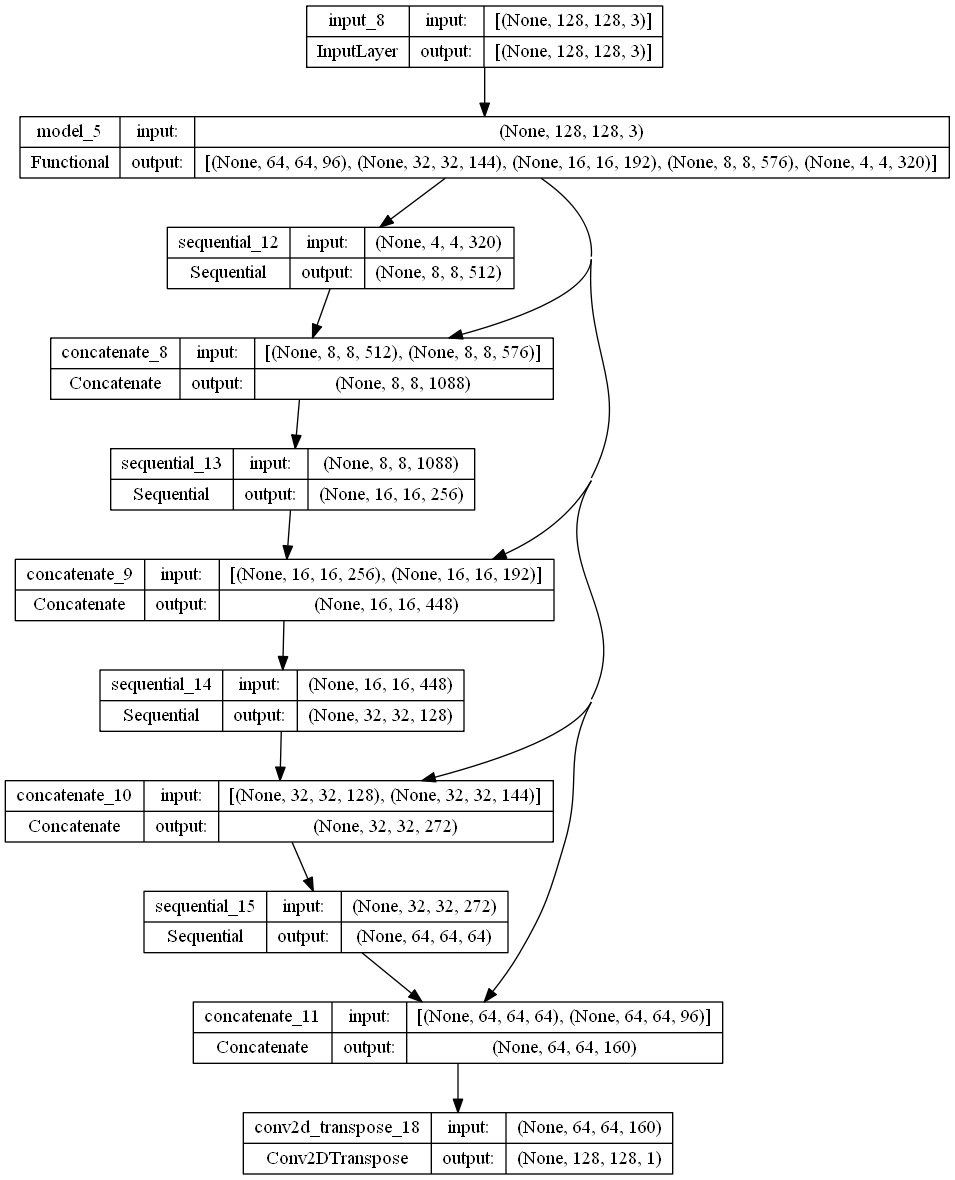

In [32]:
#Plot base model, MobileNetV2 and model, U-Net
tf.keras.utils.plot_model(model, show_shapes=True)

Running the model and save the update on the model.h5 file

In [30]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)]

results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=25, callbacks=callbacks)
#model.save("model_3")

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.3787 - accuracy: 0.8276
Epoch 1: val_loss improved from inf to 1.50110, saving model to model_for_nuclei.h5
34/34 [==============================] - 6s 157ms/step - loss: 1.3787 - accuracy: 0.8276 - val_loss: 1.5011 - val_accuracy: 0.8060
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4549 - accuracy: 0.8121
Epoch 2: val_loss improved from 1.50110 to 1.24778, saving model to model_for_nuclei.h5
34/34 [==============================] - 4s 125ms/step - loss: 1.4549 - accuracy: 0.8121 - val_loss: 1.2478 - val_accuracy: 0.8511
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3151 - accuracy: 0.8347
Epoch 3: val_loss improved from 1.24778 to 1.21523, saving model to model_for_nuclei.h5
34/34 [==============================] - 4s 124ms/step - loss: 1.3151 - accuracy: 0.8347 - val_loss: 1.2152 - val_accuracy: 0.8473
Epoch 4/25
34/34 [==============================] - ETA: 0s - los

Loading the model to make prediction

In [34]:
#load the model
model = keras.models.load_model('./model_for_nuclei.h5')

In [35]:
idx = random.randint(0, len(X_train))

#predicting model using features, X_train
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

3/3 [==============================] - 1s 419ms/step


In [36]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

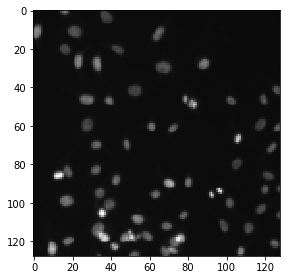

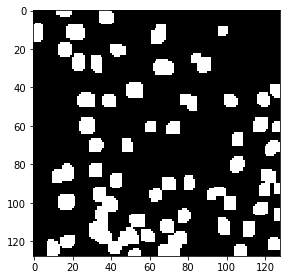

C:\Users\User\anaconda3\envs\andirian98\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


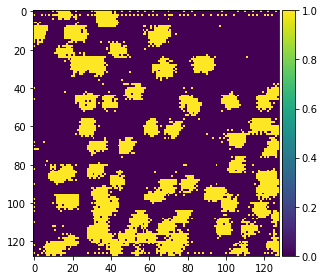

In [37]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

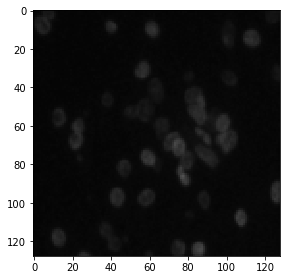

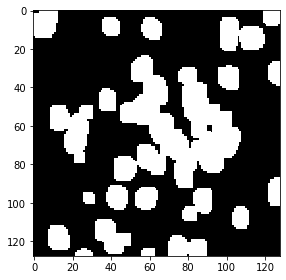

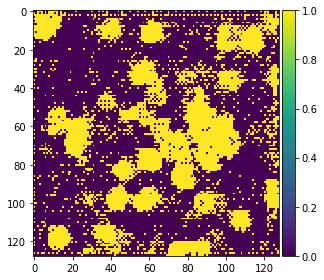

In [38]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

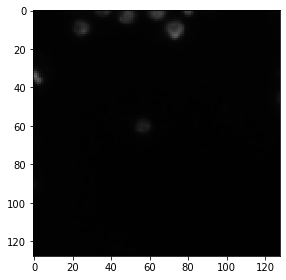

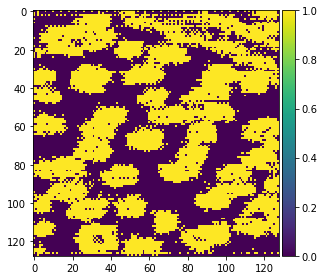

In [39]:
# Perform a sanity check on some random testing dataset samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_test.shape[0]*0.9):][ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]))
plt.show()